In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Ruta a tus datos limpios
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"

# Función para calcular AC/DC de una señal
def compute_ac_dc(signal):
    ac = np.std(signal)
    dc = np.mean(signal)
    return ac / dc if dc != 0 else np.nan

# Cargar todos los archivos y extraer valores
ratios = []
spo2_values = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        match = re.search(r"raw_data_(\d+)_\d+", filename)
        if match:
            spo2 = int(match.group(1))
            path = os.path.join(folder_path, filename)
            df = pd.read_csv(path)

            if "RED_net" in df.columns and "IR_net" in df.columns:
                red_ratio = compute_ac_dc(df["RED_net"])
                ir_ratio = compute_ac_dc(df["IR_net"])

                if not np.isnan(red_ratio) and not np.isnan(ir_ratio) and ir_ratio != 0:
                    R = red_ratio / ir_ratio
                    ratios.append(R)
                    spo2_values.append(spo2)

# Crear tabla original
lut_df = pd.DataFrame({"R": ratios, "SpO2": spo2_values}).sort_values("R").reset_index(drop=True)
lut_df


,R,SpO2
0,-26.740089,93
1,-17.404535,98
2,0.111614,91
3,0.567304,95
4,0.610433,97
5,0.748128,96
6,0.829299,95
7,0.923467,96
8,1.179835,98
9,1.878349,95


In [3]:
# Calcular pendiente media
delta_spo2 = lut_df["SpO2"].diff().dropna()
delta_r = lut_df["R"].diff().dropna()
pendiente_media = (delta_spo2 / delta_r).mean()

print(f"Cada vez que R sube 1, la SpO₂ baja aproximadamente {abs(pendiente_media):.2f} puntos porcentuales")


Cada vez que R sube 1, la SpO₂ baja aproximadamente 4.17 puntos porcentuales


In [4]:
# Punto de partida (valor de R más alto que tienes)
r_inicio = lut_df["R"].max()
spo2_inicio = lut_df.loc[lut_df["R"].idxmax(), "SpO2"]

# Rango extendido de R hacia valores más altos
r_nuevos = np.arange(r_inicio, r_inicio + 3.1, 0.1)  # hasta R+3 con paso 0.1
spo2_estimadas = spo2_inicio + pendiente_media * (r_nuevos - r_inicio)
spo2_estimadas = np.clip(spo2_estimadas, 70, 100)  # mantener valores realistas

# Crear nueva tabla
lut_extendida = pd.DataFrame({
    "R": r_nuevos,
    "SpO2_estimado": spo2_estimadas
})

lut_extendida.head()


,R,SpO2_estimado
0,17.630574,97.000000
1,17.730574,97.417253
2,17.830574,97.834506
3,17.930574,98.251758
4,18.030574,98.669011


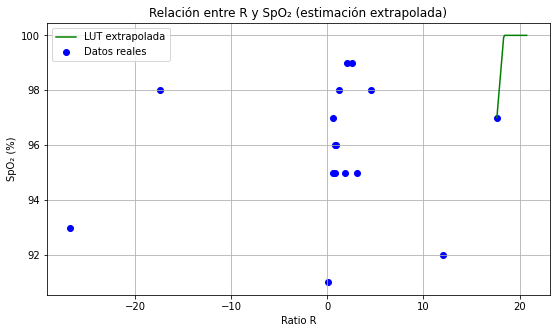

In [5]:
plt.figure(figsize=(9, 5))
plt.scatter(lut_df["R"], lut_df["SpO2"], color="blue", label="Datos reales")
plt.plot(lut_extendida["R"], lut_extendida["SpO2_estimado"], color="green", label="LUT extrapolada")
plt.xlabel("Ratio R")
plt.ylabel("SpO₂ (%)")
plt.title("Relación entre R y SpO₂ (estimación extrapolada)")
plt.grid(True)
plt.legend()
plt.show()


In [6]:
# 1. Usamos la pendiente media que ya has calculado
pendiente = pendiente_media  # ya calculada antes

# 2. Punto de referencia alto
r_ref = lut_df["R"].max()
spo2_ref = lut_df.loc[lut_df["R"].idxmax(), "SpO2"]

# 3. Rango completo que quieres para tu tabla
r_tabla = np.arange(0, 5.01, 0.01)  # puedes subir hasta 6.0 si quieres más

# 4. Estimar la SpO2 para cada R
spo2_tabla = spo2_ref + pendiente * (r_tabla - r_ref)
spo2_tabla = np.clip(spo2_tabla, 70, 100)

# 5. Crear tabla LUT final
tabla_lut = pd.DataFrame({
    "R": r_tabla,
    "SpO2_estimada": spo2_tabla
})

# 6. Visualizar parte de la tabla
tabla_lut.head(10)


,R,SpO2_estimada
0,0.00,70.0
1,0.01,70.0
2,0.02,70.0
3,0.03,70.0
4,0.04,70.0
5,0.05,70.0
6,0.06,70.0
7,0.07,70.0
8,0.08,70.0
9,0.09,70.0
